In [1]:
import pandas as pd

data = pd.read_csv('data/dataframe_final.csv', index_col=0)
label = pd.read_csv('data/label_final.csv', index_col=0)
data_std = pd.read_csv('data/dataframe_std.csv', index_col=0)

In [2]:
import numpy as np
from datetime import datetime

def create_sequences(s_year, dataframe, label):
    Xs, ys = [], []
    curday = datetime(s_year, 1, 1)
    dayformat = curday.strftime('%Y-%m-%d')
    for idx in dataframe.index:
        if idx != dayformat:
            X = dataframe.loc[dayformat].values
            y = label.loc[dayformat].values
            
            s = np.arange(X.shape[0])
            np.random.shuffle(s)
            X = X[s]
            y = y[s]
            
            Xs.append(X)
            ys.append(y)
            dayformat = idx
        
    return np.array(Xs, dtype=object), np.array(ys, dtype=object)

In [3]:
X, y = create_sequences(1963, data, label)
X.shape, y.shape

((3131,), (3131,))

In [4]:
stdX, y = create_sequences(1963, data_std, label)
stdX.shape, y.shape

((3131,), (3131,))

In [5]:
def sequenceFlatter(X):
    temp = []
    for x in X:
        for i in x:
            temp.append(i)
    temp = np.array(temp)
    return temp

In [6]:
X = sequenceFlatter(X)
stdX = sequenceFlatter(stdX)
y = sequenceFlatter(y)

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
X_train_std, X_test_std, y_train, y_test = train_test_split(stdX, y, test_size=0.2, shuffle=False)


[4.77522471e+06 2.16876884e+06 7.84751909e+05 2.44225447e+05
 1.14568203e+05 6.77054887e+04 5.05492916e+04 4.62079310e+04
 2.13026858e+04 1.00379157e+04 2.18982542e-01]
[5.76485233e-01 2.61822906e-01 9.47385546e-02 2.94839243e-02
 1.38311558e-02 8.17369167e-03 6.10252331e-03 5.57841598e-03
 2.57174993e-03 1.21181944e-03 2.64364945e-08]


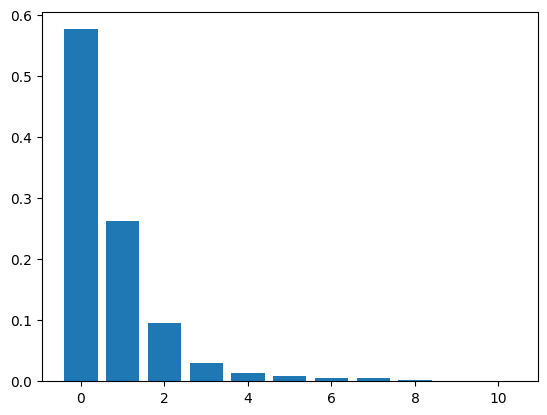

In [8]:
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(X_train)

print(pca.explained_variance_)
print(pca.explained_variance_ratio_)

x_length = len(X_train[0])
x = np.arange(x_length)

import matplotlib.pyplot as plt 

plt.bar(x, pca.explained_variance_ratio_)
plt.show()

[3.18943325 1.6487713  1.13678767 0.92970555 0.8693268  0.7727962
 0.7405737  0.67902388 0.56807619 0.47277524 0.25481331]
[0.28320101 0.14640021 0.10093938 0.08255183 0.07719059 0.0686193
 0.06575815 0.06029292 0.05044148 0.04197938 0.02262577]


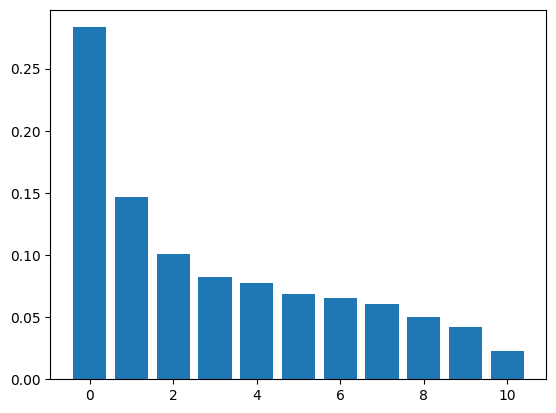

In [9]:
pca_std = PCA()
pca_std.fit(X_train_std)

print(pca_std.explained_variance_)
print(pca_std.explained_variance_ratio_)

plt.bar(x, pca_std.explained_variance_ratio_)
plt.show()

In [15]:
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

X_train_std_pca = pca_std.fit_transform(X_train_std)
X_test_std_pca = pca_std.transform(X_test_std)

[0.55728146 0.07507966 0.0615703  0.05439116 0.05324177 0.04963205
 0.04241489 0.03941599 0.03644652 0.02678254 0.00374366]


c:\Users\PC\CommunityAnalitics\.venv\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


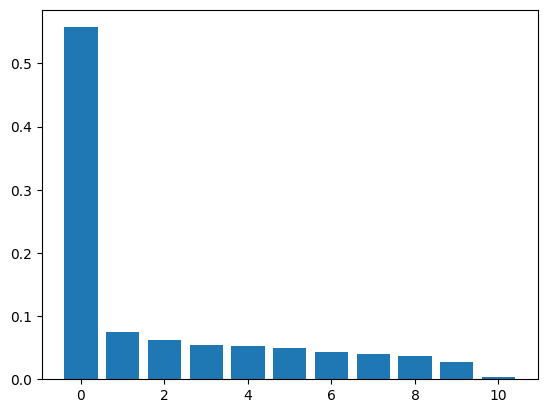

In [16]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)
print(lda.explained_variance_ratio_)

plt.bar(x, lda.explained_variance_ratio_)
plt.show()

[9.93704873e-01 3.34210569e-03 8.89075212e-04 5.00969077e-04
 4.18684147e-04 3.02774653e-04 2.64781086e-04 2.24009812e-04
 1.84184258e-04 1.53027412e-04 1.55160050e-05]


c:\Users\PC\CommunityAnalitics\.venv\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


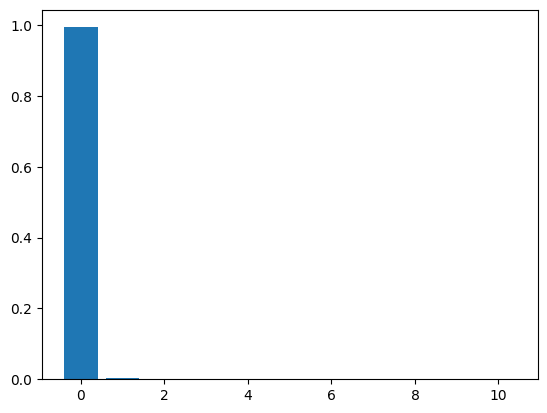

In [17]:
lda_std = LinearDiscriminantAnalysis()
lda_std.fit(X_train_std, y_train)
print(lda_std.explained_variance_ratio_)

plt.bar(x, lda_std.explained_variance_ratio_)
plt.show()

[0.55728146 0.07507966 0.0615703  0.05439116 0.05324177 0.04963205
 0.04241489 0.03941599 0.03644652 0.02678254 0.00374366]


c:\Users\PC\CommunityAnalitics\.venv\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


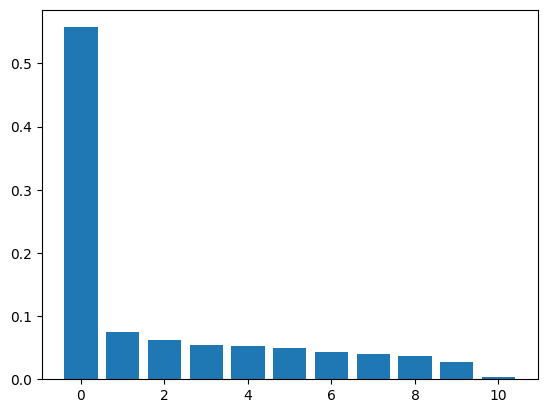

In [18]:
lda_pca = LinearDiscriminantAnalysis()
lda_pca.fit(X_train_pca, y_train)
print(lda_pca.explained_variance_ratio_)

plt.bar(x, lda_pca.explained_variance_ratio_)
plt.show()

[9.93704873e-01 3.34210569e-03 8.89075212e-04 5.00969077e-04
 4.18684147e-04 3.02774653e-04 2.64781086e-04 2.24009812e-04
 1.84184258e-04 1.53027412e-04 1.55160050e-05]


c:\Users\PC\CommunityAnalitics\.venv\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


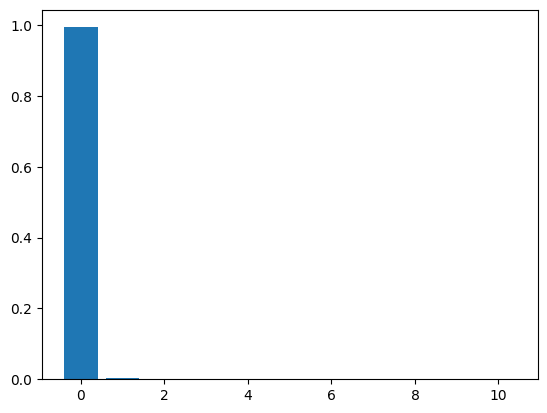

In [19]:
lda_std_pca = LinearDiscriminantAnalysis()
lda_std_pca.fit(X_train_std_pca, y_train)
print(lda_std_pca.explained_variance_ratio_)

plt.bar(x, lda_std_pca.explained_variance_ratio_)
plt.show()

In [20]:
X_train_lda = lda.transform(X_train)
X_test_lda = lda.transform(X_test)

X_train_std_lda = lda_std.transform(X_train_std)
X_test_std_lda = lda_std.transform(X_test_std)

X_train_pca_lda = lda_pca.transform(X_train_pca)
X_test_pca_lda = lda_pca.transform(X_test_pca)

X_train_std_pca_lda = lda_std_pca.transform(X_train_std_pca)
X_test_std_pca_lda = lda_std_pca.transform(X_test_std_pca)

In [47]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_val_score

def modelingAndVisualizing(X_train, X_test, title):
    knn = KNeighborsRegressor(n_neighbors=3)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    
    train_score = knn.score(X_train, y_train)
    test_score = knn.score(X_test, y_test)

    print(title)
    print('학습 정확도 : ', round(train_score, 3))
    print('검증 정확도 : ', round(test_score, 3))
    print("평균 정확도", np.mean(cross_val_score(knn, X_train, y_train, cv=5)))
    
    plt.plot(range(100), y_test[:100], label='True')
    plt.plot(range(100), y_pred[:100], label='Predicted')
    plt.title(title)
    plt.legend()
    plt.show()
    return knn

Original
학습 정확도 :  0.314
검증 정확도 :  -0.329
평균 정확도 -0.34329845123063807


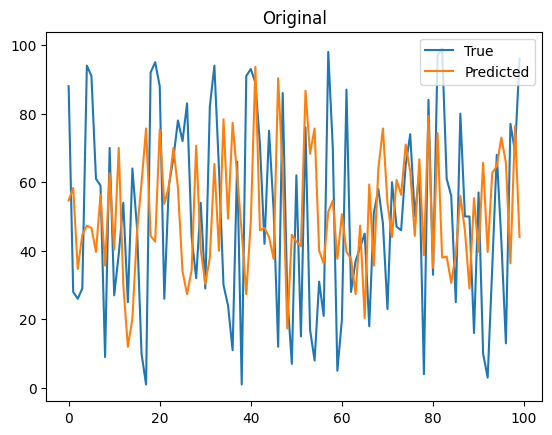

Standardized
학습 정확도 :  0.956
검증 정확도 :  -0.996
평균 정확도 -0.9424453841165507


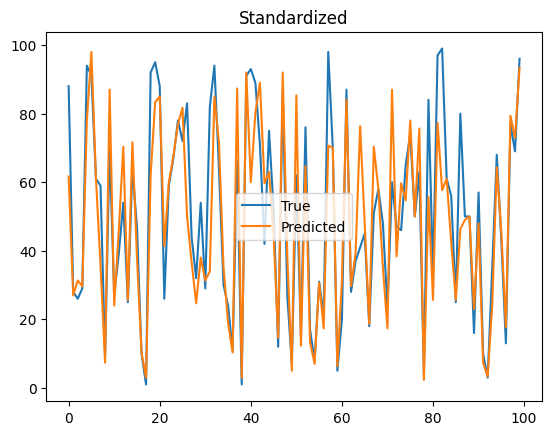

PCA
학습 정확도 :  0.314
검증 정확도 :  -0.329
평균 정확도 -0.3246772258517353


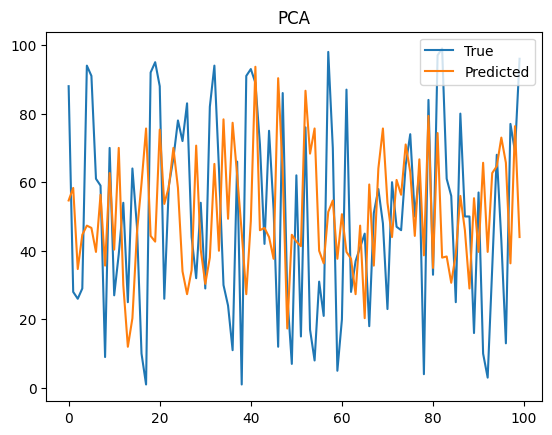

Standardized_PCA
학습 정확도 :  0.956
검증 정확도 :  -0.996
평균 정확도 -0.9424441765135182


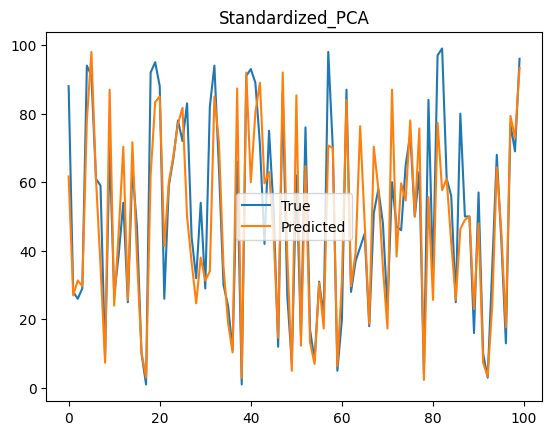

LDA
학습 정확도 :  0.315
검증 정확도 :  -0.322
평균 정확도 -0.34140529305229533


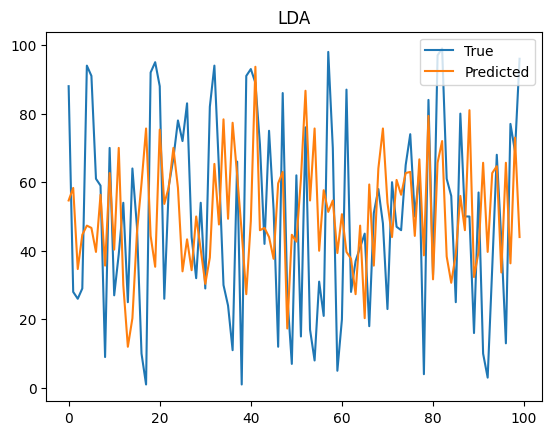

Standardized_LDA
학습 정확도 :  0.957
검증 정확도 :  -0.97
평균 정확도 -0.9475002376131887


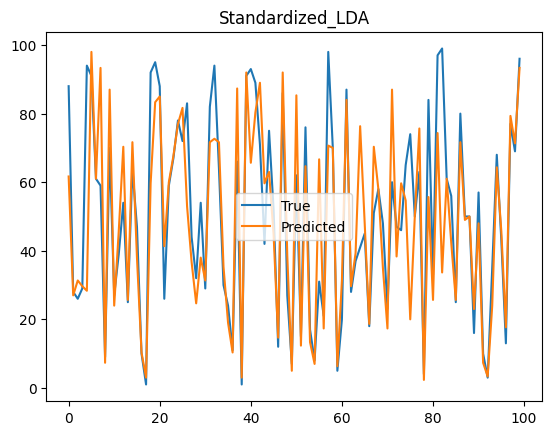

PCA_LDA
학습 정확도 :  0.314
검증 정확도 :  -0.322
평균 정확도 -0.32459230339177175


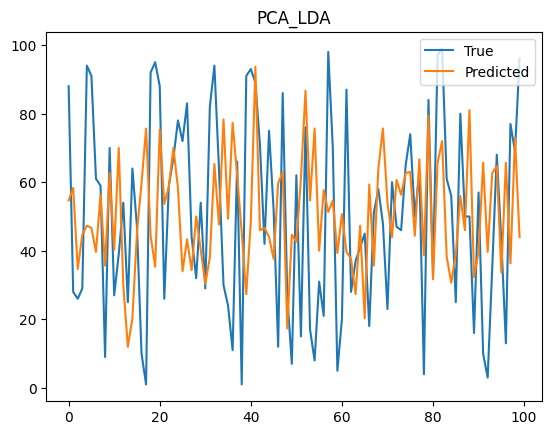

Standardized_PCA_LDA
학습 정확도 :  0.957
검증 정확도 :  -0.97
평균 정확도 -0.9475002376131887


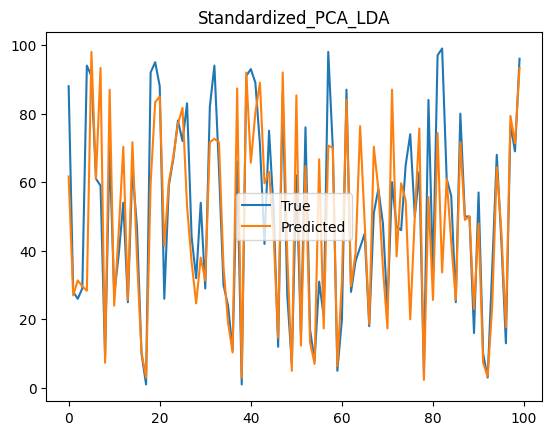

In [48]:
modelingList = [
    (X_train, X_test, 'Original'),
    (X_train_std, X_test_std, 'Standardized'),
    (X_train_pca, X_test_pca, 'PCA'),
    (X_train_std_pca, X_test_std_pca, 'Standardized_PCA'),
    (X_train_lda, X_test_lda, 'LDA'),
    (X_train_std_lda, X_test_std_lda, 'Standardized_LDA'),
    (X_train_pca_lda, X_test_pca_lda, 'PCA_LDA'),
    (X_train_std_pca_lda, X_test_std_pca_lda, 'Standardized_PCA_LDA')
]

import joblib
import os

for model in modelingList:
    knn = modelingAndVisualizing(*model)
    # save model to file
    if not os.path.exists('models'):
        os.makedirs('models')
        filePath = 'models/' + model[2] + '.pkl'
        joblib.dump(knn, filePath)
    

In [28]:
data2023 = pd.read_csv('data/dataframes/dataframe_2023to2023.csv', index_col=0)
label2023 = pd.read_csv('data/dataframes/label_2023to2023.csv', index_col=0)

In [29]:
data2023['date'] = data2023['date'] + 835
data2023

,date,danceability,energy,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
2023-01-01,835,12,206,574,1,106,333,0,31,173,414
2023-01-01,835,173,97,666,1,172,524,0,358,463,547
2023-01-01,835,300,74,652,1,91,527,0,21,430,113
2023-01-01,835,283,100,47,1,34,350,199,327,476,42
2023-01-01,835,240,50,49,1,43,514,0,41,466,322
...,...,...,...,...,...,...,...,...,...,...,...
2023-12-31,887,187,381,100,1,247,223,0,317,404,416
2023-12-31,887,262,361,196,0,319,189,0,318,434,30
2023-12-31,887,92,331,273,1,38,311,22,158,240,393
2023-12-31,887,344,427,253,0,125,347,142,176,475,167


In [30]:
X2023, y2023 = create_sequences(2023, data2023, label2023)
X2023 = X2023.reshape(X2023.shape[0]*X2023.shape[1], X2023.shape[2])
y2023 = y2023.reshape(y2023.shape[0]*y2023.shape[1], 1)

In [31]:
from sklearn.preprocessing import StandardScaler

std = StandardScaler()
std.fit(X_train)
X2023_std = std.transform(X2023)

In [40]:
X2023_pca = pca.transform(X2023)
X2023_std_pca = pca_std.transform(X2023_std)
X2023_lda = lda.transform(X2023)
X2023_std_lda = lda_std.transform(X2023_std)
X2023_pca_lda = lda_pca.transform(X2023_pca)
X2023_std_pca_lda = lda_std_pca.transform(X2023_std_pca)

In [46]:
list2023 = [
    (X2023, 'Original'),
    (X2023_std, 'Standardized'),
    (X2023_pca, 'PCA'),
    (X2023_std_pca, 'Standardized_PCA'),
    (X2023_lda, 'LDA'),
    (X2023_std_lda, 'Standardized_LDA'),
    (X2023_pca_lda, 'PCA_LDA'),
    (X2023_std_pca_lda, 'Standardized_PCA_LDA')
]

filePath = f'models/KNN_{list2023[0][1]}.pkl'
model = joblib.load(filePath)
print(list2023[0][1])

y_pred = model.predict(list2023[0][0])
print('정확도 : ', model.score(list2023[0][0], y2023))
plt.plot(range(100), y2023[:100], label='True')
plt.plot(range(100), y_pred[:100], label='Predicted')
plt.title(list2023[0][1])
plt.legend()
plt.show()

Original


AttributeError: 'NoneType' object has no attribute 'predict'

In [49]:
def modelingAndVisualizing2023(X_train, y_train, data, label, title):
    knn = KNeighborsRegressor(n_neighbors=3)
    knn.fit(X_train, y_train)
    pred = knn.predict(data)
    
    train_score = knn.score(X_train, y_train)

    print(title)
    print('학습 정확도 : ', round(train_score, 3))
    print("평균 예측 정확도", np.mean(cross_val_score(knn, data, label, cv=5)))
    
    plt.plot(range(100), label[:100], label='True 2023')
    plt.plot(range(100), pred[:100], label='Predicted')
    plt.title(title)
    plt.legend()
    plt.show()
    return knn

In [50]:
listFor2023 = [
    (X_train, y_train, X2023, y2023, 'Original'),
    (X_train_std, y_train, X2023_std, y2023, 'Standardized'),
    (X_train_pca, y_train, X2023_pca, y2023, 'PCA'),
    (X_train_std_pca, y_train, X2023_std_pca, y2023, 'Standardized_PCA'),
    (X_train_lda, y_train, X2023_lda, y2023, 'LDA'),
    (X_train_std_lda, y_train, X2023_std_lda, y2023, 'Standardized_LDA'),
    (X_train_pca_lda, y_train, X2023_pca_lda, y2023, 'PCA_LDA'),
    (X_train_std_pca_lda, y_train, X2023_std_pca_lda, y2023, 'Standardized_PCA_LDA')
]

Original
학습 정확도 :  0.314
평균 예측 정확도 0.29804684957447536


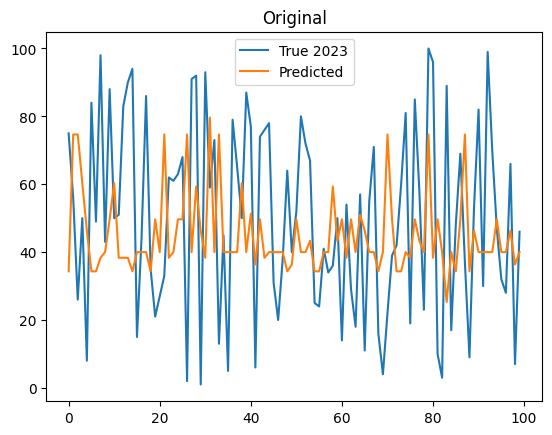

Standardized
학습 정확도 :  0.956
평균 예측 정확도 0.33658077433377487


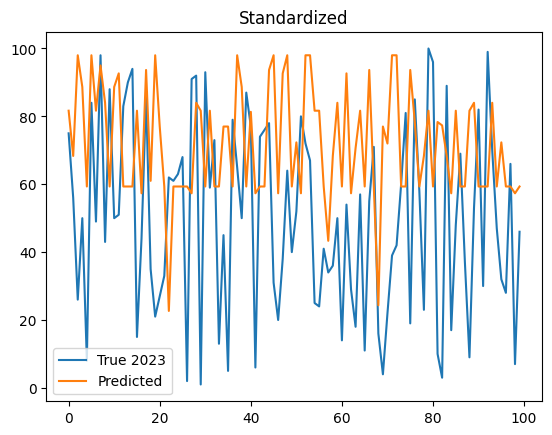

PCA
학습 정확도 :  0.314
평균 예측 정확도 0.2984738340452856


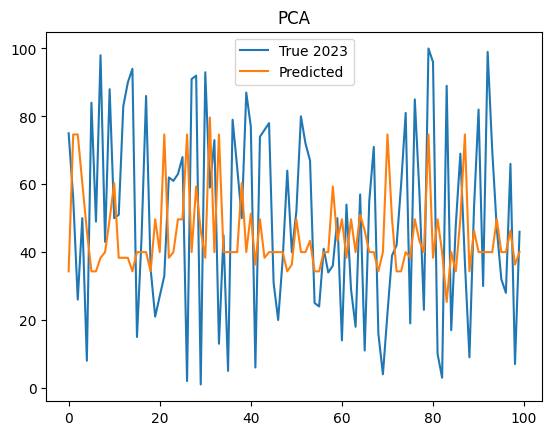

Standardized_PCA
학습 정확도 :  0.956
평균 예측 정확도 0.3364319729245996


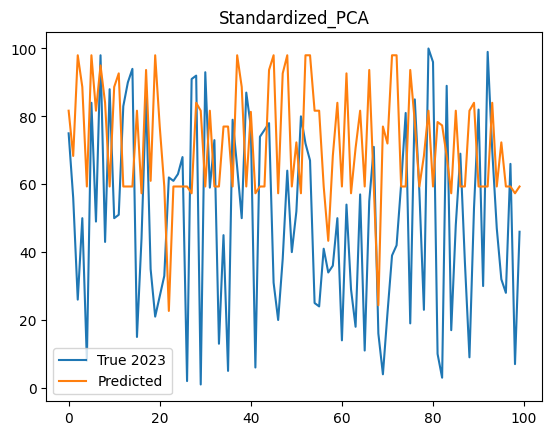

LDA
학습 정확도 :  0.315
평균 예측 정확도 0.36367415903522643


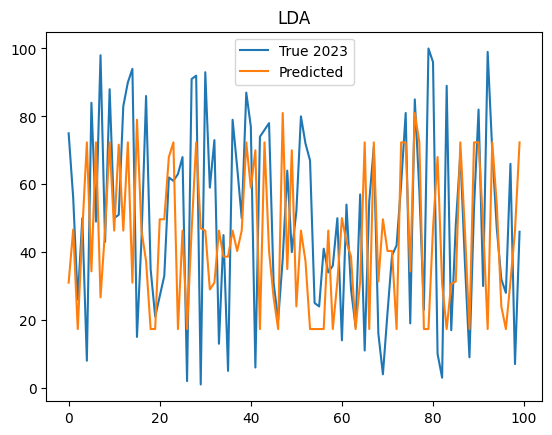

Standardized_LDA
학습 정확도 :  0.957
평균 예측 정확도 0.36518597996940994


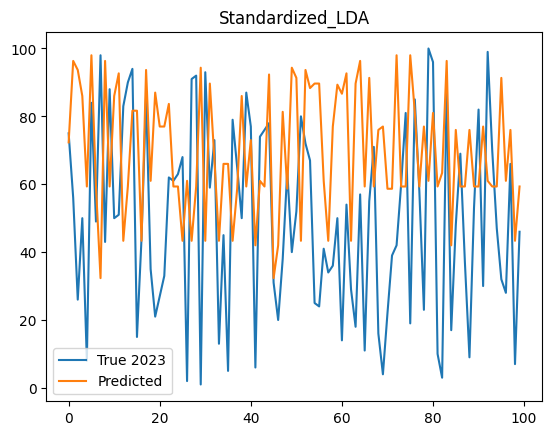

PCA_LDA
학습 정확도 :  0.314
평균 예측 정확도 0.3642638546218511


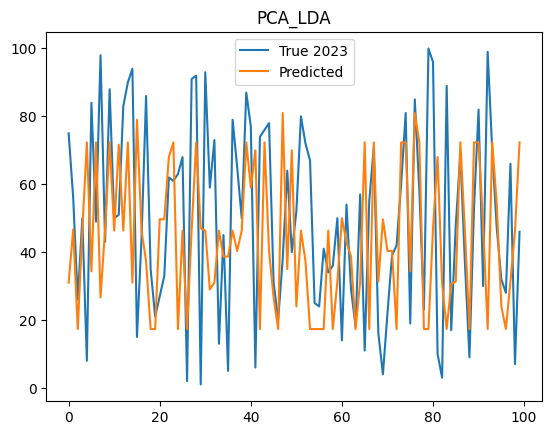

Standardized_PCA_LDA
학습 정확도 :  0.957
평균 예측 정확도 0.3659287028666337


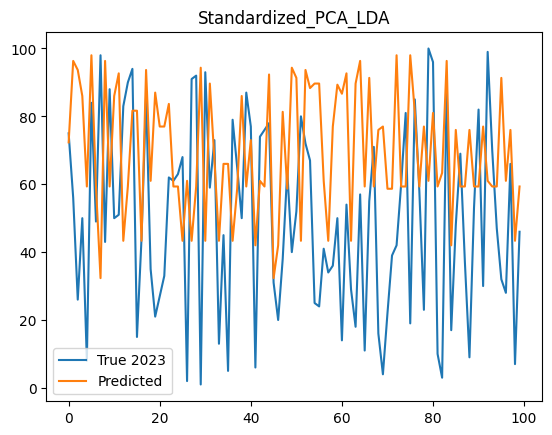

In [52]:
for model in listFor2023:
    modelingAndVisualizing2023(*model)